In [1]:
!pip install tf-nightly

     |████████████████████████████████| 519.3MB 30kB/s 
     |████████████████████████████████| 3.0MB 27.5MB/s 
     |████████████████████████████████| 460kB 47.9MB/s 


In [2]:
import tensorflow as tf
print("Tensor Flow Verion: " + tf.__version__)
tf.test.gpu_device_name()

Tensor Flow Verion: 2.2.0-dev20200422


'/device:GPU:0'

In [8]:
!pip install kaggle
!mkdir .kaggle
import json
token = {"username":"mingzhehu","key":"92235045fd85f95ca75fb5844cc352ff"}

with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!chmod 600 /content/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/kermany2018 -p /content

mkdir: cannot create directory ‘.kaggle’: File exists
- path is now set to: {/content}
100% 10.8G/10.8G [04:17<00:00, 65.2MB/s]
100% 10.8G/10.8G [04:17<00:00, 45.1MB/s]


In [0]:
!unzip \*.zip

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.layers import ELU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
import numpy as np
import os
import cv2
from os import listdir
from os.path import isfile, join
import re
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import plot_model
import matplotlib.image as mpimg
%matplotlib inline

**Load the model**

In [11]:
cd /content/drive/My Drive/Detecting Retina Damage from Speckle Noise Polluted OCT-Retinal Images

/content/drive/My Drive/Detecting Retina Damage from Speckle Noise Polluted OCT-Retinal Images


In [0]:
model = tf.keras.models.load_model('VGG16/saved_model/VGG16_model')

**Add noise to test data**

Noise free

In [0]:
validation_datagen = ImageDataGenerator(rescale=1./255)

In [74]:
cd /content

/content


In [0]:
train_data_dir = 'OCT2017 /train'
validation_data_dir = 'OCT2017 /test'

In [0]:
num_classes = 4
img_rows, img_cols = 224, 224
batch_size = 16
nb_train_samples = 83484
nb_validation_samples = 968

In [77]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 968 images belonging to 4 classes.


In [78]:
scores = model.evaluate_generator(validation_generator,steps=nb_validation_samples // batch_size+1, verbose=1)
print('\nTest result: %.3f loss: %.3f' %(scores[1]*100,scores[0]))

61/61 [==============================] - 3s 55ms/step - loss: 0.2430 - accuracy: 0.9401

Test result: 94.008 loss: 0.243


In [0]:
validation_datagen = ImageDataGenerator(rescale=1./255)

In [80]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 968 images belonging to 4 classes.


In [0]:
class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()} 
classes = list(class_labels.values())

In [0]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples//batch_size + 1)
y_pred_label = np.argmax(y_pred, axis=1)

Confusion Matrix
[[235   3   4   0]
 [  3 214   1  24]
 [  9   1 219  13]
 [  0   0   0 242]]


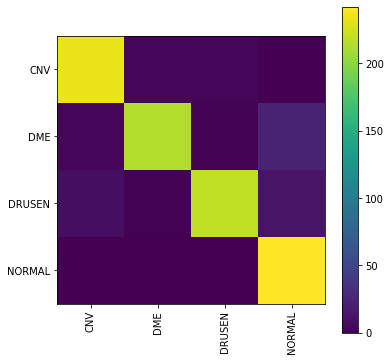

In [83]:
print("Confusion Matrix")
print(confusion_matrix(validation_generator.classes, y_pred_label))

plt.figure(figsize=(6,6))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred_label)
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
plt.clim(0, 242)
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

In [84]:
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))

Classification Report
              precision    recall  f1-score   support

         CNV       0.95      0.97      0.96       242
         DME       0.98      0.88      0.93       242
      DRUSEN       0.98      0.90      0.94       242
      NORMAL       0.87      1.00      0.93       242

    accuracy                           0.94       968
   macro avg       0.94      0.94      0.94       968
weighted avg       0.94      0.94      0.94       968



sigma = 0.01

In [0]:
from skimage.util import random_noise

def AddSpeckle(img, level=1):
  img = img/255.0
  noise = level * np.random.normal(0, 0.01 ** 0.5, img.shape)
  img_speckled = img + img * noise
  out = np.clip(img_speckled, 0, 1.0)
  return out

In [0]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)

In [87]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 968 images belonging to 4 classes.


In [88]:
scores = model.evaluate_generator(validation_generator,steps=nb_validation_samples // batch_size+1, verbose=1)
print('\nTest result: %.3f loss: %.3f' %(scores[1]*100,scores[0]))

61/61 [==============================] - 11s 174ms/step - loss: 0.2945 - accuracy: 0.9236

Test result: 92.355 loss: 0.294


In [89]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 968 images belonging to 4 classes.


Confusion Matrix
[[227   6   8   1]
 [  3 204   1  34]
 [  7   2 216  17]
 [  0   0   0 242]]
Classification Report
              precision    recall  f1-score   support

         CNV       0.96      0.94      0.95       242
         DME       0.96      0.84      0.90       242
      DRUSEN       0.96      0.89      0.93       242
      NORMAL       0.82      1.00      0.90       242

    accuracy                           0.92       968
   macro avg       0.93      0.92      0.92       968
weighted avg       0.93      0.92      0.92       968



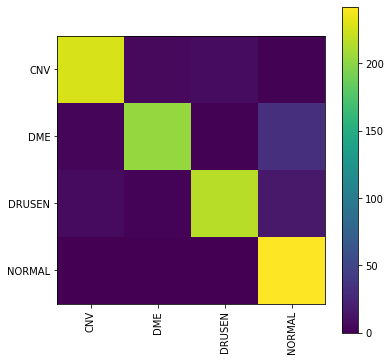

In [90]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples//batch_size + 1)
y_pred_label = np.argmax(y_pred, axis=1)
print("Confusion Matrix")
print(confusion_matrix(validation_generator.classes, y_pred_label))

plt.figure(figsize=(6,6))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred_label)
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
plt.clim(0, 242)
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))

sigma = 0.02

In [0]:
from skimage.util import random_noise

def AddSpeckle(img, level=1):
  img = img/255.0
  noise = level * np.random.normal(0, 0.02 ** 0.5, img.shape)
  img_speckled = img + img * noise
  out = np.clip(img_speckled, 0, 1.0)
  return out

In [0]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)

In [93]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 968 images belonging to 4 classes.


In [94]:
scores = model.evaluate_generator(validation_generator,steps=nb_validation_samples // batch_size+1, verbose=1)
print('\nTest result: %.3f loss: %.3f' %(scores[1]*100,scores[0]))

61/61 [==============================] - 11s 174ms/step - loss: 0.3264 - accuracy: 0.9070

Test result: 90.702 loss: 0.326


In [95]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 968 images belonging to 4 classes.


Confusion Matrix
[[227   5   9   1]
 [  3 196   0  43]
 [  2   2 219  19]
 [  0   0   0 242]]
Classification Report
              precision    recall  f1-score   support

         CNV       0.98      0.94      0.96       242
         DME       0.97      0.81      0.88       242
      DRUSEN       0.96      0.90      0.93       242
      NORMAL       0.79      1.00      0.88       242

    accuracy                           0.91       968
   macro avg       0.92      0.91      0.91       968
weighted avg       0.92      0.91      0.91       968



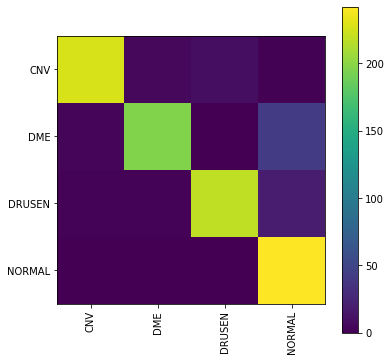

In [96]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples//batch_size + 1)
y_pred_label = np.argmax(y_pred, axis=1)
print("Confusion Matrix")
print(confusion_matrix(validation_generator.classes, y_pred_label))

plt.figure(figsize=(6,6))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred_label)
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
plt.clim(0, 242)
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))

sigma = 0.04

In [0]:
from skimage.util import random_noise

def AddSpeckle(img, level=1):
  img = img/255.0
  noise = level * np.random.normal(0, 0.04 ** 0.5, img.shape)
  img_speckled = img + img * noise
  out = np.clip(img_speckled, 0, 1.0)
  return out

In [0]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)

In [99]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 968 images belonging to 4 classes.


In [100]:
scores = model.evaluate_generator(validation_generator,steps=nb_validation_samples // batch_size+1, verbose=1)
print('\nTest result: %.3f loss: %.3f' %(scores[1]*100,scores[0]))

61/61 [==============================] - 11s 175ms/step - loss: 0.3353 - accuracy: 0.9029

Test result: 90.289 loss: 0.335


In [101]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 968 images belonging to 4 classes.


Confusion Matrix
[[226   9   6   1]
 [  3 195   0  44]
 [ 10   3 211  18]
 [  0   0   1 241]]
Classification Report
              precision    recall  f1-score   support

         CNV       0.95      0.93      0.94       242
         DME       0.94      0.81      0.87       242
      DRUSEN       0.97      0.87      0.92       242
      NORMAL       0.79      1.00      0.88       242

    accuracy                           0.90       968
   macro avg       0.91      0.90      0.90       968
weighted avg       0.91      0.90      0.90       968



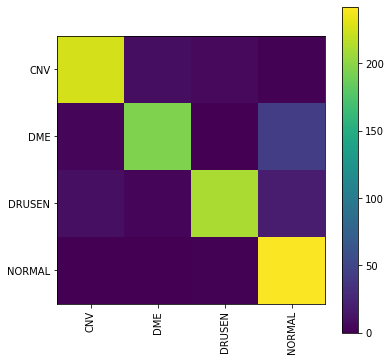

In [102]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples//batch_size + 1)
y_pred_label = np.argmax(y_pred, axis=1)
print("Confusion Matrix")
print(confusion_matrix(validation_generator.classes, y_pred_label))

plt.figure(figsize=(6,6))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred_label)
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
plt.clim(0, 242)
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))

sigma = 0.08

In [0]:
from skimage.util import random_noise

def AddSpeckle(img, level=1):
  img = img/255.0
  noise = level * np.random.normal(0, 0.08 ** 0.5, img.shape)
  img_speckled = img + img * noise
  out = np.clip(img_speckled, 0, 1.0)
  return out

In [0]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)

In [105]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 968 images belonging to 4 classes.


In [106]:
scores = model.evaluate_generator(validation_generator,steps=nb_validation_samples // batch_size+1, verbose=1)
print('\nTest result: %.3f loss: %.3f' %(scores[1]*100,scores[0]))

61/61 [==============================] - 11s 173ms/step - loss: 0.3482 - accuracy: 0.8895

Test result: 88.946 loss: 0.348


In [107]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 968 images belonging to 4 classes.


Confusion Matrix
[[228  10   3   1]
 [  3 190   0  49]
 [ 15   6 203  18]
 [  0   0   1 241]]
Classification Report
              precision    recall  f1-score   support

         CNV       0.93      0.94      0.93       242
         DME       0.92      0.79      0.85       242
      DRUSEN       0.98      0.84      0.90       242
      NORMAL       0.78      1.00      0.87       242

    accuracy                           0.89       968
   macro avg       0.90      0.89      0.89       968
weighted avg       0.90      0.89      0.89       968



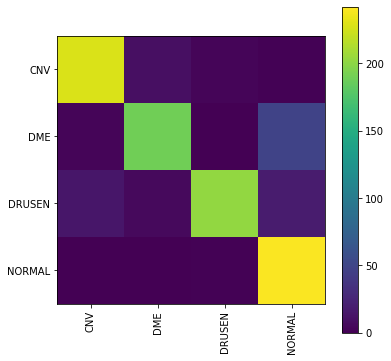

In [108]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples//batch_size + 1)
y_pred_label = np.argmax(y_pred, axis=1)
print("Confusion Matrix")
print(confusion_matrix(validation_generator.classes, y_pred_label))

plt.figure(figsize=(6,6))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred_label)
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
plt.clim(0, 242)
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))

sigma = 0.16

In [0]:
from skimage.util import random_noise

def AddSpeckle(img, level=1):
  img = img/255.0
  noise = level * np.random.normal(0, 0.16 ** 0.5, img.shape)
  img_speckled = img + img * noise
  out = np.clip(img_speckled, 0, 1.0)
  return out

In [0]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)

In [111]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 968 images belonging to 4 classes.


In [112]:
scores = model.evaluate_generator(validation_generator,steps=nb_validation_samples // batch_size+1, verbose=1)
print('\nTest result: %.3f loss: %.3f' %(scores[1]*100,scores[0]))

61/61 [==============================] - 11s 174ms/step - loss: 0.3968 - accuracy: 0.8523

Test result: 85.227 loss: 0.397


In [113]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 968 images belonging to 4 classes.


Confusion Matrix
[[218  22   0   2]
 [  4 195   1  42]
 [ 34  11 173  24]
 [  0   0   2 240]]
Classification Report
              precision    recall  f1-score   support

         CNV       0.85      0.90      0.88       242
         DME       0.86      0.81      0.83       242
      DRUSEN       0.98      0.71      0.83       242
      NORMAL       0.78      0.99      0.87       242

    accuracy                           0.85       968
   macro avg       0.87      0.85      0.85       968
weighted avg       0.87      0.85      0.85       968



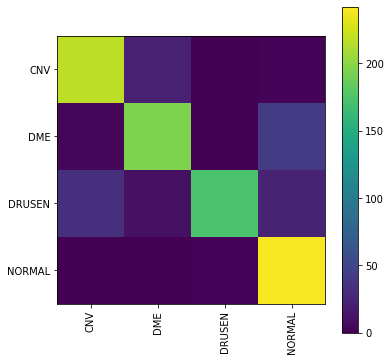

In [114]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples//batch_size + 1)
y_pred_label = np.argmax(y_pred, axis=1)
print("Confusion Matrix")
print(confusion_matrix(validation_generator.classes, y_pred_label))

plt.figure(figsize=(6,6))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred_label)
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
plt.clim(0, 242)
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))

sigma = 0.32

In [0]:
from skimage.util import random_noise

def AddSpeckle(img, level=1):
  img = img/255.0
  noise = level * np.random.normal(0, 0.32 ** 0.5, img.shape)
  img_speckled = img + img * noise
  out = np.clip(img_speckled, 0, 1.0)
  return out

In [0]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)

In [117]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 968 images belonging to 4 classes.


In [118]:
scores = model.evaluate_generator(validation_generator,steps=nb_validation_samples // batch_size+1, verbose=1)
print('\nTest result: %.3f loss: %.3f' %(scores[1]*100,scores[0]))

61/61 [==============================] - 11s 175ms/step - loss: 0.5666 - accuracy: 0.7748

Test result: 77.479 loss: 0.567


In [119]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 968 images belonging to 4 classes.


Confusion Matrix
[[212  29   0   1]
 [  6 191   4  41]
 [ 83  14 116  29]
 [  1   9   4 228]]
Classification Report
              precision    recall  f1-score   support

         CNV       0.70      0.88      0.78       242
         DME       0.79      0.79      0.79       242
      DRUSEN       0.94      0.48      0.63       242
      NORMAL       0.76      0.94      0.84       242

    accuracy                           0.77       968
   macro avg       0.80      0.77      0.76       968
weighted avg       0.80      0.77      0.76       968



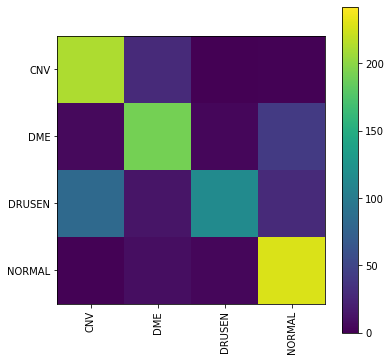

In [120]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples//batch_size + 1)
y_pred_label = np.argmax(y_pred, axis=1)
print("Confusion Matrix")
print(confusion_matrix(validation_generator.classes, y_pred_label))

plt.figure(figsize=(6,6))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred_label)
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
plt.clim(0, 242)
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))

Sigma = 0.64

In [0]:
from skimage.util import random_noise

def AddSpeckle(img, level=1):
  img = img/255.0
  noise = level * np.random.normal(0, 0.64 ** 0.5, img.shape)
  img_speckled = img + img * noise
  out = np.clip(img_speckled, 0, 1.0)
  return out

In [0]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)

In [123]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 968 images belonging to 4 classes.


In [124]:
scores = model.evaluate_generator(validation_generator,steps=nb_validation_samples // batch_size+1, verbose=1)
print('\nTest result: %.3f loss: %.3f' %(scores[1]*100,scores[0]))

61/61 [==============================] - 11s 177ms/step - loss: 0.9065 - accuracy: 0.6240

Test result: 62.397 loss: 0.906


In [125]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 968 images belonging to 4 classes.


Confusion Matrix
[[186  39   1  16]
 [ 17 178   4  43]
 [112  18  45  67]
 [ 10  46   9 177]]
Classification Report
              precision    recall  f1-score   support

         CNV       0.57      0.77      0.66       242
         DME       0.63      0.74      0.68       242
      DRUSEN       0.76      0.19      0.30       242
      NORMAL       0.58      0.73      0.65       242

    accuracy                           0.61       968
   macro avg       0.64      0.61      0.57       968
weighted avg       0.64      0.61      0.57       968



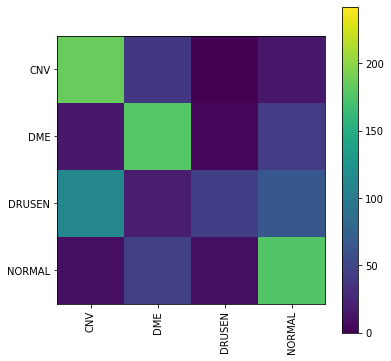

In [126]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples//batch_size + 1)
y_pred_label = np.argmax(y_pred, axis=1)
print("Confusion Matrix")
print(confusion_matrix(validation_generator.classes, y_pred_label))

plt.figure(figsize=(6,6))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred_label)
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
plt.clim(0, 242)
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))

sigma = 1.28

In [0]:
from skimage.util import random_noise

def AddSpeckle(img, level=1):
  img = img/255.0
  noise = level * np.random.normal(0, 1.28 ** 0.5, img.shape)
  img_speckled = img + img * noise
  out = np.clip(img_speckled, 0, 1.0)
  return out

In [0]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)

In [129]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 968 images belonging to 4 classes.


In [130]:
scores = model.evaluate_generator(validation_generator,steps=nb_validation_samples // batch_size+1, verbose=1)
print('\nTest result: %.3f loss: %.3f' %(scores[1]*100,scores[0]))

61/61 [==============================] - 11s 180ms/step - loss: 1.2797 - accuracy: 0.4711

Test result: 47.107 loss: 1.280


In [131]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 968 images belonging to 4 classes.


Confusion Matrix
[[117  69   3  53]
 [ 24 145   1  72]
 [ 75  17  15 135]
 [ 23  33  11 175]]
Classification Report
              precision    recall  f1-score   support

         CNV       0.49      0.48      0.49       242
         DME       0.55      0.60      0.57       242
      DRUSEN       0.50      0.06      0.11       242
      NORMAL       0.40      0.72      0.52       242

    accuracy                           0.47       968
   macro avg       0.49      0.47      0.42       968
weighted avg       0.49      0.47      0.42       968



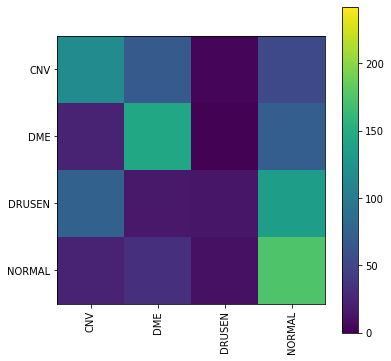

In [132]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples//batch_size + 1)
y_pred_label = np.argmax(y_pred, axis=1)
print("Confusion Matrix")
print(confusion_matrix(validation_generator.classes, y_pred_label))

plt.figure(figsize=(6,6))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred_label)
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
plt.clim(0, 242)
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))